In [1]:
from torch import nn
import torch
import pandas as pd
import numpy as np
import os
from torchvision.io import read_image
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import transforms3d as tf

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transformer_model = nn.Transformer(batch_first=True)
BATCH_SIZE = 1
ENC_SEQ_LEN = 10
DEC_SEQ_LEN = 1
src = torch.rand((BATCH_SIZE, ENC_SEQ_LEN, transformer_model.d_model))
tgt = torch.rand((BATCH_SIZE, DEC_SEQ_LEN, transformer_model.d_model))
out = transformer_model(src, tgt)
out.flatten(start_dim=1).shape, out.shape

(torch.Size([1, 512]), torch.Size([1, 1, 512]))

In [3]:
encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=3, batch_first=True)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
transformer_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
      )
      (linear1): Linear(in_features=6, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=6, bias=True)
      (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
      )
      (linear1): Linear(in_features=6, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=6, bias=True)


In [4]:
BATCH_SIZE = 1
ENC_SEQ_LEN = 15
src = torch.rand(BATCH_SIZE, ENC_SEQ_LEN, encoder_layer.self_attn.embed_dim)
out = transformer_encoder(src)
ENC_SEQ_LEN = 16
src = torch.rand(BATCH_SIZE, ENC_SEQ_LEN, encoder_layer.self_attn.embed_dim)
out = transformer_encoder(src)
out.shape, src

(torch.Size([1, 16, 6]),
 tensor([[[0.9960, 0.1840, 0.9166, 0.1576, 0.3282, 0.6186],
          [0.5033, 0.9850, 0.4159, 0.7266, 0.8434, 0.6737],
          [0.1165, 0.9924, 0.4289, 0.0602, 0.9136, 0.1293],
          [0.1992, 0.0434, 0.6226, 0.5787, 0.7486, 0.1262],
          [0.0390, 0.4337, 0.2142, 0.1993, 0.7941, 0.4149],
          [0.0416, 0.1350, 0.1898, 0.4434, 0.5155, 0.8086],
          [0.9855, 0.2031, 0.2567, 0.3443, 0.0018, 0.1694],
          [0.2582, 0.9947, 0.8184, 0.4547, 0.2818, 0.9297],
          [0.0605, 0.5767, 0.9452, 0.1806, 0.2441, 0.3827],
          [0.0187, 0.9951, 0.1606, 0.7907, 0.1547, 0.0104],
          [0.6215, 0.2278, 0.6684, 0.1890, 0.6152, 0.7104],
          [0.6272, 0.2966, 0.0653, 0.9272, 0.8218, 0.6319],
          [0.1691, 0.4096, 0.7631, 0.7574, 0.9790, 0.8576],
          [0.7782, 0.3407, 0.9217, 0.9965, 0.3694, 0.8432],
          [0.2768, 0.8335, 0.2162, 0.5431, 0.6287, 0.5304],
          [0.5689, 0.5399, 0.5434, 0.0238, 0.8135, 0.3804]]]))

In [5]:
data_dir = "indoor_forward_9_snapdragon_with_gt/"
imu_cols=["timestamp", "ang_vel_x", "ang_vel_y", "ang_vel_z", "lin_acc_x", "lin_acc_y", "lin_acc_z"]
imu_df = pd.read_csv(data_dir + "imu.txt", delimiter=' ', skiprows=1, names=imu_cols)
imu_df_nostamp = imu_df.loc[:, imu_df.columns != 'timestamp']
imu_df.index = pd.to_datetime(imu_df["timestamp"], unit='s')
imu_df

,timestamp,ang_vel_x,ang_vel_y,ang_vel_z,lin_acc_x,lin_acc_y,lin_acc_z
timestamp,,,,,,,
2018-10-29 14:20:16.292325120,1.540823e+09,-0.006392,-0.008522,-0.007457,0.052672,-0.158017,9.797023
2018-10-29 14:20:16.294326016,1.540823e+09,-0.005326,-0.006392,-0.006392,0.000000,-0.129286,9.768292
2018-10-29 14:20:16.296323072,1.540823e+09,-0.010653,-0.007457,-0.001065,-0.033519,-0.100556,9.749139
2018-10-29 14:20:16.298322944,1.540823e+09,-0.009587,-0.009587,-0.002131,0.043095,-0.110133,9.725197
2018-10-29 14:20:16.300322048,1.540823e+09,-0.005326,-0.005326,-0.004261,0.047884,-0.134075,9.782658
...,...,...,...,...,...,...,...
2018-10-29 14:21:33.118321920,1.540823e+09,-0.214118,-0.024501,0.415453,-5.956743,-0.397435,7.086801
2018-10-29 14:21:33.120321024,1.540823e+09,-0.238619,0.060720,0.476173,7.110743,1.402995,5.717324
2018-10-29 14:21:33.122322944,1.540823e+09,-0.295078,0.106526,0.288687,-3.969566,-0.181958,16.136837


In [6]:
imu_data = imu_df_nostamp.to_numpy(dtype=np.float32)
imu_data = torch.from_numpy(imu_data)
imu_data

tensor([[-6.3916e-03, -8.5221e-03, -7.4569e-03,  5.2672e-02, -1.5802e-01,
          9.7970e+00],
        [-5.3263e-03, -6.3916e-03, -6.3916e-03,  0.0000e+00, -1.2929e-01,
          9.7683e+00],
        [-1.0653e-02, -7.4569e-03, -1.0653e-03, -3.3519e-02, -1.0056e-01,
          9.7491e+00],
        ...,
        [-2.9508e-01,  1.0653e-01,  2.8869e-01, -3.9696e+00, -1.8196e-01,
          1.6137e+01],
        [-7.8830e-02, -7.3503e-02,  4.6019e-01, -1.6280e+00,  9.0979e-02,
          1.6472e+00],
        [-3.4834e-01,  3.0893e-02,  3.9202e-01,  6.1435e+00,  2.1596e+00,
          9.7204e+00]])

In [7]:
src = imu_data[:ENC_SEQ_LEN].unsqueeze(0)
transformer_encoder(src)

tensor([[[-0.3392,  0.1044, -0.8690,  0.0046, -0.9529,  2.0520],
         [-0.2893,  0.1572, -1.2785,  0.1014, -0.6473,  1.9565],
         [-0.3747,  0.0981, -1.3113, -0.0143, -0.3919,  1.9941],
         [-0.6792,  0.0955, -1.0115,  0.2148, -0.6341,  2.0145],
         [-0.2906,  0.1072, -1.2951,  0.2320, -0.6799,  1.9263],
         [-0.5304,  0.1931, -1.3113,  0.1120, -0.4084,  1.9449],
         [-0.4220,  0.2657, -1.1217,  0.1861, -0.8437,  1.9356],
         [-0.4014, -0.0094, -1.2824,  0.2265, -0.5051,  1.9718],
         [-0.5309,  0.0611, -1.2043,  0.0694, -0.4166,  2.0213],
         [-0.2392, -0.2759, -1.2175,  0.2208, -0.5075,  2.0194],
         [-0.1777, -0.0338, -1.1217,  0.0489, -0.7510,  2.0353],
         [-0.2702, -0.0752, -0.9222,  0.1945, -0.9562,  2.0294],
         [-0.3078, -0.0169, -1.2403,  0.1886, -0.6124,  1.9889],
         [-0.2816,  0.1038, -1.1077,  0.1390, -0.8421,  1.9886],
         [-0.2483,  0.0442, -1.3384,  0.2332, -0.6169,  1.9262],
         [-0.3810,  0.159

In [8]:
class IMUDataset(Dataset):
    def __init__(self, data_dir, label_file, seq_len):
        imu_cols=["timestamp", "ang_vel_x", "ang_vel_y", "ang_vel_z", "lin_acc_x", "lin_acc_y", "lin_acc_z"]
        self.imu_df = pd.read_csv(data_dir + "imu.txt", delimiter=' ', skiprows=1, names=imu_cols)
        self.imu_df.index = pd.to_datetime(self.imu_df["timestamp"], unit='s')
        imu_df_nostamp = self.imu_df.loc[:, self.imu_df.columns != 'timestamp']
        self.imu_data = imu_df_nostamp.to_numpy(dtype=np.float32)
        self.imu_data = torch.from_numpy(self.imu_data)

        label_cols=["timestamp","tx","ty","tz","qx","qy","qz","qw","none"]
        self.labels_df = pd.read_csv(label_file, delimiter=' ', skiprows=1, names=label_cols)
        self.labels_df = self.labels_df.iloc[: , :-1]
        self.labels_df["timestamp"] = pd.to_datetime(self.labels_df["timestamp"], unit='s')
        labels_df_nostamp = self.labels_df.loc[:, self.labels_df.columns != 'timestamp']
        self.labels = torch.tensor(labels_df_nostamp.to_numpy(), dtype=torch.float32)

        self.seq_len = seq_len
        self.delta = seq_len

    def __len__(self):
        return self.labels.shape[0] - self.delta

    def __getitem__(self, idx):
        # TODO: could optimize for better performance (pretty quick anyway)
        label_ts = self.labels_df.iloc[idx]["timestamp"]
        label_ts_end = self.labels_df.iloc[idx+self.delta]["timestamp"]

        dpose = torch.zeros(7)
        l1 = self.labels[idx]
        l2 = self.labels[idx+self.delta]
        dl = l2-l1 # position delta
        dpose[:3] = dl[:3]
        q1 = l1[3:][[3,0,1,2]] # rearange quaternion, w goes first
        q2 = l2[3:][[3,0,1,2]] # rearange quaternion, w goes first
        dq = tf.quaternions.qmult(q2, tf.quaternions.qinverse(q1)) # orientation delta
        dpose[3:] = torch.tensor(dq, dtype=torch.float32) # pose delta is the label

        imu_index_start = self.imu_df.index.get_loc(label_ts, method='nearest')
        imu_index_end = self.imu_df.index.get_loc(label_ts_end, method='nearest')
        imu = self.imu_data[imu_index_start:imu_index_end]

        return imu, dpose

ENC_SEQ_LEN = 256
vio_dataset = IMUDataset(data_dir, data_dir + "groundtruth.txt", ENC_SEQ_LEN)
vio_dataset.__getitem__(500)

(tensor([[-2.8443e-01, -9.9070e-02, -1.5766e-01,  3.7110e+00, -2.7294e-01,
           1.4705e+01],
         [ 3.4088e-02, -1.5766e-01, -5.3263e-02, -6.9958e+00, -5.6982e-01,
           9.7108e+00],
         [ 3.1532e-01,  1.3955e-01,  1.8323e-01,  1.0343e+00,  7.4220e-01,
           4.2617e-01],
         ...,
         [-5.3263e-03,  3.1958e-03,  1.7577e-01,  5.9520e+00, -3.4381e+00,
          -7.2783e-01],
         [-2.0879e-01,  1.8216e-01,  2.3436e-02, -5.6982e-01,  1.9584e+00,
           1.3929e+01],
         [ 1.0759e-01,  2.2158e-01,  1.5659e-01, -3.9696e+00,  6.1770e-01,
           6.6606e+00]]),
 tensor([ 0.0131,  0.0138,  0.0249, -0.9997,  0.0065, -0.0240,  0.0039]))

In [9]:
import time
s = time.time()
for i in range(1000):
    vio_dataset.__getitem__(i)
dt = time.time() - s
dt / 1000, dt # fast enough :?)

(0.0020020077228546144, 2.0020077228546143)

In [10]:
data_point = vio_dataset.__getitem__(0)[0].unsqueeze(0)
transformer_encoder(data_point).shape

torch.Size([1, 256, 6])

In [11]:
class IMUTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=6, dim_feedforward=32, batch_first=True)
        transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.encoder = transformer_encoder
        self.fc1 = nn.Linear(in_features=6, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=7)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.relu(self.fc1(x[:,-1,:]))
        x = self.fc2(x)
        return x

model = IMUTransformer()
model(data_point)

tensor([[-0.0659, -0.0721,  0.2274, -0.1626,  0.2377, -0.0530, -0.1521]],
       grad_fn=<AddmmBackward0>)

In [26]:
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # .01 works for initial ~20 epochs
dataloader = torch.utils.data.DataLoader(vio_dataset, batch_size=64*2, shuffle=True, num_workers=4)
next(iter(dataloader))[0].shape

torch.Size([128, 256, 6])

In [27]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html training loop from here

torch.cuda.empty_cache()

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(vio_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f}')

Epoch 0/4
----------
train Loss: 0.0312
Epoch 1/4
----------
train Loss: 0.0301
Epoch 2/4
----------
train Loss: 0.0301
Epoch 3/4
----------
train Loss: 0.0287
Epoch 4/4
----------
train Loss: 0.0293


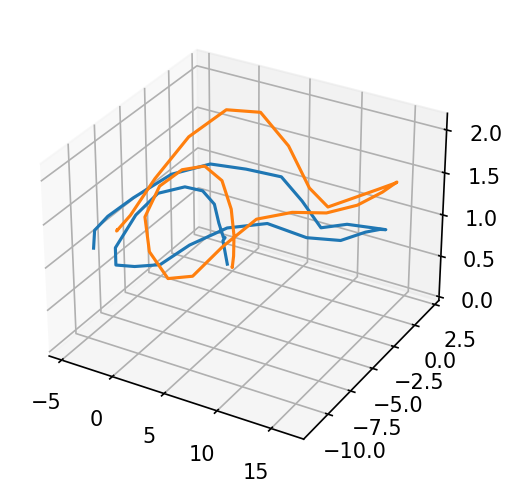

In [28]:
model.eval()
path = []
ground = []
x = np.zeros((3,1))
gtx = np.zeros((3,1))
for i in range(34):
    data_point = vio_dataset.__getitem__(i*ENC_SEQ_LEN)
    delta_label = data_point[1].numpy().reshape(7,1)[:3]
    gtx += delta_label
    ground.append(gtx.copy())
    inputs = data_point[0].unsqueeze(0).to(device)
    outputs = model(inputs)
    dx = outputs.cpu().detach().numpy().T[:3]
    x += dx
    path.append(x.copy())
path = np.array(path).reshape(-1,3)
ground = np.array(ground).reshape(-1,3)
fig = plt.figure(dpi=150)
ax = plt.axes(projection='3d')
ax.plot3D(path[:,0],path[:,1],path[:,2])
ax.plot3D(ground[:,0],ground[:,1],ground[:,2])
# 11,24

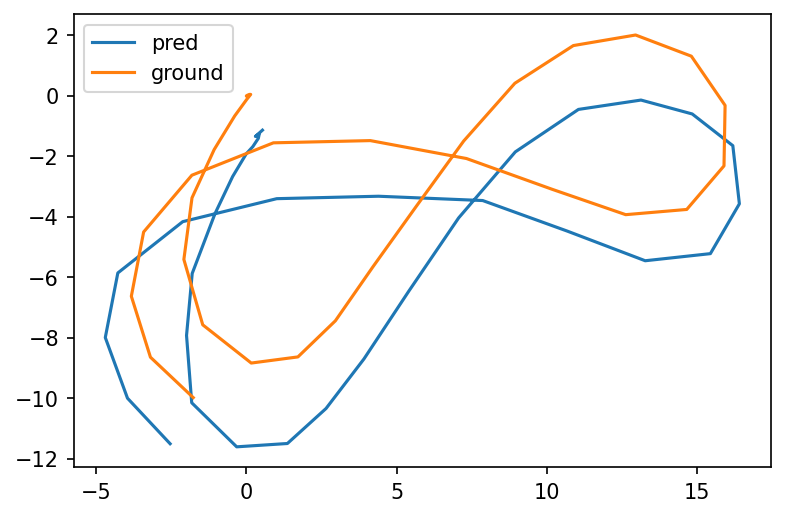

In [29]:
plt.figure(dpi=150)
plt.plot(path[:,0],path[:,1])
plt.plot(ground[:,0],ground[:,1])
plt.legend(["pred","ground"])

In [97]:
np.linalg.norm(path[-1] - ground[-1]) # how far away from the actual, at the end of trajectory ?

1.7122096990249858

In [95]:
df = vio_dataset.imu_df
integrated_path = []
integ = np.zeros((3,1))
for index in range(len(df)-1):
    curr = df.iloc[index+1]
    prev = df.iloc[index]
    dt = (curr["timestamp"] - prev["timestamp"])
    acceleration = np.array([
        curr["lin_acc_x"],
        curr["lin_acc_y"],
        curr["lin_acc_z"]
    ]).reshape((3,1))
    integ += 1/2*acceleration*dt**2
    integrated_path.append(integ.copy())
integrated_path = np.array(integrated_path).reshape(-1,3)
integrated_path.shape

(38417, 3)

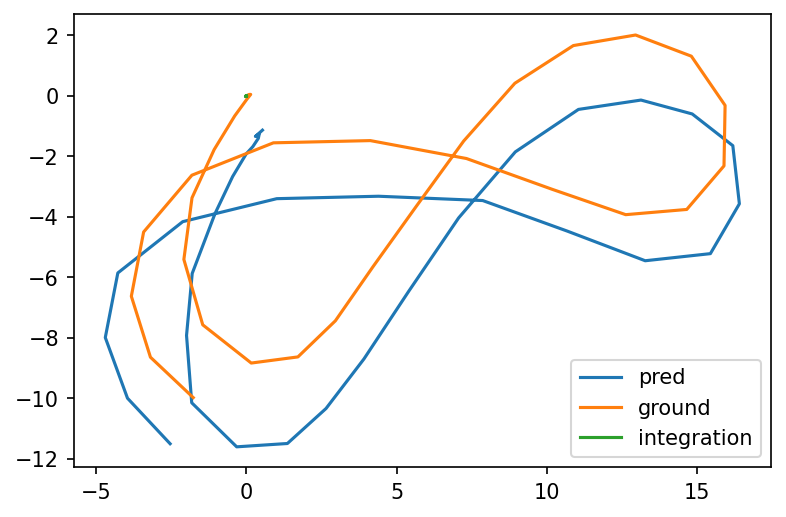

In [96]:
plt.figure(dpi=150)
plt.plot(path[:,0],path[:,1])
plt.plot(ground[:,0],ground[:,1])
plt.plot(integrated_path[:,0],integrated_path[:,1])
plt.legend(["pred","ground","integration"])